[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bsc-life/ml4br-ml-course/blob/main/nbs/day_3/04_PyTorch.ipynb)

# Basic Neural Network

We are going to code the neural network we just saw in the slides. We will use PyTorch to do this. Confusingly enough, in python, PyTorch is just called `torch`. So, when you see `torch`, it is referring to the PyTorch library.

`torch` has many submodules. The most important ones are:
- `torch.nn`: this is the module that contains all the neural network functions and classes, like layers, activation functions, etc.
- `torch.optim`: this is the module that contains all the optimization functions and classes, like SGD, Adam, etc.

We are also going to need `torch.nn.functional`, which contains all the functions that are not classes, like activation functions, loss functions, etc.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pandas.tests.arrays.integer.test_repr import test_dtypes
from torch.optim import SGD

import matplotlib.pyplot as plt

Networks in PyTorch are specified through Python classes. These are basically a collection of functions. We define a class with `class`, give it a name, and declare if there's another class from which it inherits some behavior, known as the parent class. We then specify which functions the class contains:

* `__init__`: this is a mandatory function
  * `self` referst to the class itself. Whenever we specify this within the class, we are telling the class that it has different parts, namely, the weights and the biases of the different neurons in our network.
  * `super`: refers to the parent function. We need to initialize it after the class.
* `forward`: which takes as arguments the class itself, and some input, i.e., the data we will train and test the model on. It is important to call it `forward` and not something else. Pytorch or, more specifically, `nn.Module` expects this function to perform backpropagation. When we call the model in our data, we will call the class like

`model=BasicNN() # Initialize the model`,

which initializes the class (i.e., it sets the parameters). While training and testing we can call the model we just initialized

`model(data) # For training and/or testing`

and this will automatically call the forward method and then perform backpropagation.



This is the most common way to work on PyTorch! It is a very flexible coduct because we can have one single code to train many different models on different datasets! Think of it just like a normal Python function: you can use it in many situations without the need to copy many lines of code. Besides, classes can inherit behavior from others, so you can add new classes with new features that also retain the behavior you already programmed elsewhere, reducing the number of lines and code you need to spend programming.


*Note: This type of programming, with classes, is known as Object-Oriented Programming (OOP) and it is very common! Just check the source code of complex packages such as `sklearn` and you will see it is mostly classes.*

In [ ]:
class BasicNN(nn.Module): # We tell the class its parent is nn.Module
  # Initiate the parameters
  def __init__(self): # Here we tell the class: "Cogito, ergo sum"
    super().__init__() # Here we intialize the parent

    self.w00=nn.Parameter(torch.tensor(1.7), requires_grad=False)
    self.b00=nn.Parameter(torch.tensor(-0.85), requires_grad=False)
    self.w01=nn.Parameter(torch.tensor(-40.8), requires_grad=False)

    self.w10=nn.Parameter(torch.tensor(12.6), requires_grad=False)
    self.b10=nn.Parameter(torch.tensor(0.0), requires_grad=False)
    self.w11=nn.Parameter(torch.tensor(2.7), requires_grad=False)

    self.final_bias=nn.Parameter(torch.tensor(-16.), requires_grad=False)
  # Perform forward pass through the neural network
  def forward(self,input):
    input_to_top_relu = input*self.w00+self.b00
    top_relu_output = F.relu(input_to_top_relu)
    scaled_top_relu_output = top_relu_output*self.w01

    input_to_bottom_relu = input*self.w10+self.b10
    bottom_relu_output = F.relu(input_to_bottom_relu)
    scaled_bottom_relu_output = bottom_relu_output*self.w11

    input_to_final_relu = scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias

    output = F.relu(input_to_final_relu)

    return output


---
## Using a Neural Network

We create the same data we had in the example. Consider three groups of patients to which three different doses of a drug are given.
* The first group receives no dose (0),
* the second group receives an intermediate dose (0.5), and
* the third group receives a high dose (1).

The effectiveness of the drug is 0 for the first group, 1 for the second group, and 0 for the third group.

To make things ever more simple, we consider just three patients, one per group.

The process to apply our neural network is very simple. It is very similar to using `sklearn`:
1. We initialize the model
2. We train the model in our data
3. We use the model to predict the effectiveness of the drug in a new patient.

You can think about the previous model as being "pre-trained": it already contains the optimal parameters needed to predict the effectiveness of the drug in a new patient. In this case, we are not going to train the model, but we are going to use it as it is.

In [ ]:
# Debug forward pass
input_doses = torch.linspace(start=0,end=1,steps=11)
model = BasicNN() # initialize the model
output_values = model(input_doses) # run the forward pass

plt.plot(input_doses.detach(),output_values.detach(),color='green',linewidth=2) # detach() is used to remove the gradient tracking, so no gradient will be backpropagated along this variable.
plt.ylabel('Effectiveness')
plt.xlabel('Dose')
plt.title('Effectiveness vs Dose')
plt.show()

---
## Training a Neural Network
It is not usually the case that we already know the optimal parameters of the model. In most cases, we need to train the model to find the optimal parameters. This is done by using a training set and a loss function.

To optimize a parameter in PyTorch, we need to set the option `requires_grad=True` when we create the parameter. This tells PyTorch that we want to compute the gradient of this parameter with respect to the loss function. The loss function is the function that we want to minimize (the difference between the predicted value and the actual value).

We are now going to optimize the final bias, i.e., the parameter that gets added to the output of the last layer. The rest of the parameters are going to be fixed.

In [ ]:
class BasicNN_train(nn.Module):
  # Initiate the parameters
  def __init__(self):
    super().__init__()

    self.w00=nn.Parameter(torch.tensor(1.7), requires_grad=False)
    self.b00=nn.Parameter(torch.tensor(-0.85), requires_grad=False)
    self.w01=nn.Parameter(torch.tensor(-40.8), requires_grad=False)

    self.w10=nn.Parameter(torch.tensor(12.6), requires_grad=False)
    self.b10=nn.Parameter(torch.tensor(0.0), requires_grad=False)
    self.w11=nn.Parameter(torch.tensor(2.7), requires_grad=False)

    self.final_bias=nn.Parameter(torch.tensor(0.), requires_grad=True) # this parameter should be optimized
  # Perform forward pass through the neural network
  def forward(self,input):
    input_to_top_relu = input*self.w00+self.b00
    top_relu_output = F.relu(input_to_top_relu)
    scaled_top_relu_output = top_relu_output*self.w01

    input_to_bottom_relu = input*self.w10+self.b10
    bottom_relu_output = F.relu(input_to_bottom_relu)
    scaled_bottom_relu_output = bottom_relu_output*self.w11

    input_to_final_relu = scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias

    output = F.relu(input_to_final_relu)

    return output

Every time we initialize the model and then call it, it will default to the `forward` method defined within the class. This method is the one that performs the forward pass through the neural network. It takes the input and returns the output of the neural network.

In [ ]:
# Debug forward pass
input_doses = torch.linspace(start=0,end=1,steps=11)
model = BasicNN_train() # initialize the model
output_values = model(input_doses) # run the forward pass

plt.plot(input_doses.detach(),output_values.detach(),color='green',linewidth=2) # detach() is used to remove the gradient tracking, so no gradient will be backpropagated along this variable.
plt.ylabel('Effectiveness')
plt.xlabel('Dose')
plt.title('Effectiveness vs Dose')
plt.show()

You can see this plot looks bad: The effectiveness goes all the way to 17! This is because the final bias is not optimized yet. The model is not able to predict the effectiveness of the drug in a new patient. We need to train the model to find the optimal final bias.

Now, to train a neural network, we need to loop through a number of epochs. In each epoch, we need to:
1. Get the input and the label (the actual value of the effectiveness of the drug in a new patient).
2. Run the forward pass through the neural network to get the output.
3. Compute the loss (the difference between the predicted value and the actual value).
4. Backpropagate the loss to compute the gradients of the parameters with respect to the loss function.
5. Update the parameters using the optimizer.


The loss function we are going to use is the Mean Squared Error (MSE). This is the most common loss function used in regression problems. It is defined as the average of the squared differences between the predicted values and the actual values. The optimizer we are going to use is Stochastic Gradient Descent (SGD). This is the most common optimizer used in deep learning. It updates the parameters using the gradients computed during backpropagation.

In [ ]:
# Train
inputs = torch.tensor([0.,0.5,1.])
labels = torch.tensor([0.,1.,0.])

# The optimizer we will use is SGD (Stochastic Gradient Descent)
optimizer = SGD(model.parameters(), lr=0.1)
criterion = nn.MSELoss() # Mean Squared Error Loss
losses = []
# We train for 100 epochs
for epoch in range(100):
  total_loss = 0
  # Loop through the training set
  for iteration in range(len(inputs)):
    # Get the input and the label
    input_i = inputs[iteration]
    label_i = labels[iteration]
    # Apply the model to the input
    output_i = model(input_i)
    # Compute the loss
    loss = criterion(output_i,label_i)
    # Backpropagate the loss
    loss.backward()
    # Add the losses to get the accumulated loss for each epoch
    total_loss += float(loss)

  losses.append(float(total_loss))

  if total_loss<0.0001:
    print(f'Num steps: {epoch}')
    break
  # Update the parameters with the optimizer
  optimizer.step()
  # Zero the gradients for the next iteration (otherwise, they will accumulate)
  optimizer.zero_grad()

  print(f'Step: {epoch} Final Bias: {model.final_bias.data}\n')
  print(f'Loss: {total_loss}')

print(f'Final Bias after Optimization: {model.final_bias.data}')

It is usually a good practice to plot the loss of your model to test whether it is learning correctly.

Has it learned the optimal final bias? The final bias should be around -16.0, which is the value we set in the first model. The loss should be around 0.0, which means that the model is able to predict the effectiveness of the drug in a new patient.

In [ ]:
plt.plot(losses,color='cornflowerblue',linewidth=2)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Loss vs Epoch')
plt.show()

Now that we have obtained the optimal final bias, we can plot the effectiveness to get the optimal plot from the first example.

In [ ]:
output_values = model(input_doses) # run the forward pass

plt.plot(input_doses,output_values.detach(),color='green',linewidth=2) # detach() is used to remove the gradient tracking, so no gradient will be backpropagated along this variable.
plt.ylabel('Effectiveness')
plt.xlabel('Dose')
plt.title('Effectiveness vs Dose')
plt.show()


## An even simpler neural network

The previous class `BasicNN` is not very flexible: Are you telling me I need to declare every weight, bias, activation layer and figure out how they are all connected? What if I need a very deep neural network with dozens of layers and hundreds of neurons???

Well, fret not! There's a much simpler way with `torch`.

Every hidden layer we just defined can easily be declared with `nn.Linear(in_features, out_features, bias=True)` with parameters:

* `in_features`: the dimensions, or size, of our input data. In this case, that's just 0 (the dose variable has just one value per patient). *Tiny question*: what order of tensor is it??
* `out_features`: the dimensions of the ouput we want. In other words, the number of neurons.

As the activation layer, we are going to use `nn.ReLu`, just like before.

We are going to wrap our neural network with two neurons and two activation functions around `nn.Sequential`, which allows you to easily combine many different layers.


Just like we did before, we can initialize some of the parameters to make training easier. We are only going to train the final bias.

Finally, the forward pass now is simply passing the input through the model we defined inside of `__init__`.

In [ ]:
class BasicNN(nn.Module):
    def __init__(self):
        super(BasicNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 2, bias=True),  # Input layer to 2 neurons
            nn.ReLU(), # Hidden activation layer
            nn.Linear(2, 1, bias=True), # Output layer with one neuron
            nn.ReLU(), # Output activation layer
        )
        # Initialize parameters and freeze non-trainable ones
        with torch.no_grad():
            # First layer parameters (frozen)
            self.model[0].weight = nn.Parameter(torch.tensor([[1.7], [12.6]]), requires_grad=False)
            self.model[0].bias = nn.Parameter(torch.tensor([-0.85, 0.0]), requires_grad=False)
            # Second layer paramters (frozen)
            self.model[2].weight = nn.Parameter(torch.tensor([[-40.8, 2.7]]), requires_grad=False)
            self.model[2].bias = nn.Parameter(torch.tensor([0.0]), requires_grad=True)

    def forward(self, x):
        x = x.view(-1, 1) # Reshape data to [1,1]
        return self.model(x).squeeze() # Ensure output has one dimension

In [ ]:
# You should always doble check the shape of your tensors!
print(torch.tensor(0).shape, torch.tensor([0]).shape, torch.tensor([0]).view(-1, 1).shape)
print(torch.tensor([0]), torch.tensor([0]).view(-1, 1))

In [ ]:
# Train
inputs = torch.tensor([0.,0.5,1.])
labels = torch.tensor([0.,1.,0.])

model = BasicNN()

# The optimizer we will use is SGD (Stochastic Gradient Descent)
optimizer = SGD(model.parameters(), lr=0.1)
criterion = nn.MSELoss() # Mean Squared Error Loss
losses = []
# We train for 100 epochs
for epoch in range(100):
  total_loss = 0
  # Loop through the training set
  for iteration in range(len(inputs)):
    # Get the input and the label
    input_i = inputs[iteration]
    label_i = labels[iteration]
    # Apply the model to the input
    output_i = model(input_i)
    # Compute the loss
    loss = criterion(output_i,label_i)
    # Backpropagate the loss
    loss.backward()
    # Add the losses to get the accumulated loss for each epoch
    total_loss += float(loss)

    losses.append(float(total_loss))

  if total_loss<0.0001:
    print(f'Num steps: {epoch}')
    break
  # Update the parameters with the optimizer
  optimizer.step()
  # Zero the gradients for the next iteration (otherwise, they will accumulate)
  optimizer.zero_grad()

  print(f'Step: {epoch} Final Bias: {model.model[2].bias}\n')
  print(f'Loss: {total_loss}')

print(f'Final Bias after Optimization: {model.model[2].bias}')

In [ ]:
# Debug forward pass
input_doses = torch.linspace(start=0,end=1,steps=11)
output_values = model(input_doses) # run the forward pass

plt.plot(input_doses.detach(),output_values.detach(),color='green',linewidth=2) # detach() is used to remove the gradient tracking, so no gradient will be backpropagated along this variable.
plt.ylabel('Effectiveness')
plt.xlabel('Dose')
plt.title('Effectiveness vs Dose')
plt.show()

# Binary Classification of a Table

Usually we do not have such simple data. In most cases, we have a lot of data and we need to train the model to find ALL the optimal parameters. In this case, we are going to use a dataset from the UCI Machine Learning Repository. This dataset contains information about breast cancer patients and whether they have benign or malignant tumors.

Neural Networks can be used to solve any of the problems you have seen so far in the course. In this case, we are going to use a neural network to solve a binary classification problem. The goal is to predict whether a tumor is benign or malignant based on the features of the tumor.

In [ ]:
! pip install ucimlrepo

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from ucimlrepo import fetch_ucirepo

# fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

# Adjust the data
X = X.to_numpy()
y = y.to_numpy()[:, 0]  # Convert targets to a 1D array
# Map 'B' to 0 and 'M' to 1
y = np.where(y == 'B', 0, 1)

It is very important in deep learning to normalize the data. This is because the neural network is very sensitive to the scale of the data. If the data is not normalized, the neural network may not be able to learn properly. In this case, we are going to use the `StandardScaler` from `sklearn` to normalize the data so that it has a mean of 0 and a standard deviation of 1.

In [ ]:
# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

Just like in the previous day, we split the data into a training and a test set. This time we need to convert them to tensors so that we can use them in PyTorch.

In [ ]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # Add dimension
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

The following class contains the neural network for a binary classifier.
The neural network has three layers:
1. The first layer has 16 neurons and uses the ReLU activation function.
2. The second layer has 8 neurons and also uses the ReLU activation function.
3. The last layer has 1 neuron and uses the Sigmoid activation function. Setting the final value of the network as one means we will get one prediction for each input. The Sigmoid function will then output a value between 0 and 1, which can be interpreted as a probability of the tumor being malignant.

This process is wrapped in the `nn.Sequential` function, which allows us to define the model in a more compact way. The nn.Sequential function takes a list of layers and creates a model that applies each layer in sequence.

The `input_size` takes the number of features in the dataset.

In [ ]:
class BreastCancerClassifier(nn.Module):
    def __init__(self, input_size):
        super(BreastCancerClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()  # Sigmoid for binary classification
        )

    def forward(self, x):
        return self.model(x)

Just like we did in the previous example, we need to define the loss function and the optimizer. In this case, we are going to use the Binary Cross-Entropy Loss (BCE) as the loss function. This is the most common loss function used in binary classification problems. The optimizer we are going to use is Adam, one of the most common optimizers used in deep learning. It implements an adaptive learning rate optimizer that is very efficient and works well in practice.

In [ ]:
# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1] # number of features
model = BreastCancerClassifier(input_size) # Initialize the model
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss; used for classification
optimizer = Adam(model.parameters(), lr=0.001)

In this case we are going to simultenously train and then test the model. This is a good practice in order to check for overfitting. After training is done, we should see that the training loss is lower than the testing loss by a small margin. This means the model has learned to generalize from the training data to data it has never seen before. If the testing loss was much higher than the training loss, it would mean that the model has overfitted to the training data and is not able to generalize to new data.

In [ ]:
# Train and test the model
epochs = 1_000
train_losses = []
test_losses = []

for epoch in range(epochs):
    # Training phase
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    train_loss = criterion(outputs, y_train)
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())

    # Testing phase
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses.append(test_loss.item())

    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

In [ ]:
# Plot training and testing losses
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(test_losses, label='Testing Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.legend()
plt.show()

Once the model is trained, we can assess it on the test data. To do so with PyTorch, we need to set the model to evaluation mode and use the `torch.no_grad()` context manager to disable gradient calculations.



In [ ]:
# Evaluate the model
model.eval() # Set the model to evaluation mode
with torch.no_grad(): # No need to compute gradients during evaluation
    predictions = model(X_test)
    predictions = (predictions > 0.5).float()  # Convert probabilities to binary predictions

Now that we have the predictions, we can compute some metrics to evaluate the model with `classification_report`:

In [ ]:
# Classification report:
from sklearn.metrics import classification_report
y_pred = predictions.numpy()
y_test_np = y_test.numpy()
print(classification_report(y_test_np, y_pred, target_names=['Benign', 'Malignant']))

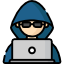

**Exercise**. There's a rather obvious disadvantage in our `BreastCancerClassifier` network. It predicts just one value for each patient. This is alright for a binary classification, but is unsuitable for multi-class classification. We can create a more general class that can be used for binary or multi-class classification. Go back to the `BreastCancerClassifier` class and modify it to accept an arbitrary number of classes. *Hint*: you only need to change two lines in total: one to update the number of classes, and another one to adjust the output. Remember, how does the data look like after the final activation layer and how does it look like before?

In the training loop, instead of using `nn.BCELoss()`, you should use `nn.CrossEntropyLoss()` for multi-class classification with the correct format.

You will also need to format again the target labels:
``` python
# Adjust the target labels for CrossEntropyLoss
y_train = y_train.squeeze().long()  # Convert to long for CrossEntropyLoss
y_test = y_test.squeeze().long()
```

Plus, the output of the model is now a matrix instead of a vector. After getting the predictions, you can set `predictions = torch.argmax(predictions, dim=1)` to get the predicted class indices.

# Image Classification (CIFAR10)

As we discussed in class, we can use a Convolutional Neural Network (CNN) to process images. In this section we are going to learn how to create a CNN with PyTorch and we are going to use it to classify different images, i.e, distinguishing the subjets of the images.

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Download the data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            # Output size formula: 1+(Input Size−Kernel Size+2×Padding)/Stride
            # Stride is 1 unless specified otherwise
            # Input is (3,32,32)
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5), # (6, 28, 28); i.e. (32-5)/1+1 = 28
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # Stride is the jump necessary to go from one element to the next one in the specified dimension dim
            # Output is (6,14,14), i.e. (28-2)/2+1=14
            nn.Conv2d(6, 16, 5), # Output: (16, 10, 10), i.e., (14-5)+1=10
            nn.ReLU(),
            nn.MaxPool2d(2, 2) # Output: (16, 5, 5), i.e., (10-2)/2+1=5
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120), # Input is the size of the last layer flattened
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10) # Output layer has size equals to the number of classes to predict
        )

    def forward(self, x):
        x = self.features(x) # First network: Convolutional
        x = self.classifier(x) # Second network: Classification
        return x

CNNs are a lot more complex than the basic neural networks we coded for processing tabular data. For this reason, it is recommended that we use a GPU to train our CNN. It is important to declare which device we are using, since tensors in the CPU and GPU cannot be operated together. We must either sum, multiply, etc. tensors in the GPU OR in the CPU. To do so, we resource to the method `.to()` which is available both in tensors and models

In [ ]:
# Initialize model and move to GPU
net = Net().to('cuda')

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

To test the model, we again need to pass the test data to the device.

In [ ]:
correct = 0
total = 0
net.eval()  # Set model to evaluation mode
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to('cuda')
        labels = labels.to('cuda')
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels.to('cuda')).sum().item()

print(f'Accuracy of the network on the 10_000 test images: {100 * correct // total} %')

In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

# Image Classification (Breast)

The previous example was a very simple one: the images were small (you could say, very pixelated), and the CNN could hardly tell them appart. Besides, it is not a very interesting case for the biologists in the room.

In the next example we are going to use a dataset of histological images of breast tissue samples, some of which show Invasive Ductal Carcinoma (IDC), a type of breast cancer (see details in [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images) or the [paper](https://doi.org/10.1117/12.2043872)).

The images are bigger and more complex. So our CNN is also going to be bigger and more complex.

*Note: you should really be using a GPU now! Otherwise, expect ~45 minutes of model training on a basic CPU.*

In [ ]:
# Download the data
import kagglehub
path = kagglehub.dataset_download("paultimothymooney/breast-histopathology-images")

print("Path to dataset files:", path)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import cv2
import glob
import random
import keras.utils as image
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# We set our device to the GPU:
device = torch.device("cuda")
device

In [ ]:
# Look for all the available images
# About 2 minutes to run
breast_img = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)

for imgname in breast_img[:3]:
    print(imgname)

In [ ]:
# Here we build two lists:
N_IDC = [] # samples with no cancer
P_IDC = [] # cancer patient samples

for img in breast_img:
    if img[-5] == '0' :
        N_IDC.append(img)

    elif img[-5] == '1' :
        P_IDC.append(img)
plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(N_IDC), 6)
some_can = np.random.randint(0, len(P_IDC), 6)

s = 0
for num in some_non:

        img = image.load_img((N_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)

        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_can:

        img = image.load_img((P_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)

        plt.subplot(6, 6, 2*s)
        plt.axis('off')
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1

In [ ]:
# Now we load the available images into memory

non_img_arr = [] # non cancer images
can_img_arr = [] # cancer images
# We will not load all of the images because it takes very long!
# for img in N_IDC[:78786]:
for img in N_IDC[:1_000]:
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])

for img in P_IDC[:1_000]:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])

In [ ]:
# Combine the two lists
breast_img_arr = non_img_arr + can_img_arr

# Shuffle the combined list
random.shuffle(breast_img_arr)

# Separate features and labels
X = [feature for feature, label in breast_img_arr]
y = [label for feature, label in breast_img_arr]

# Convert to NumPy arrays; this is for scaling and data splitting
X = np.array(X)
y = np.array(y)

In [ ]:
# MinMax Scale the data:
# sklearn takes too long so instead:
X_scaled = X.astype('float32')
X_scaled /= 255.0


In [ ]:
# Split data into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y,train_size=0.8, test_size=0.2,stratify=y)

# If you manage to load all of the images, you can split the data while also
# sub-sampling, i.e., selecting less samples than available:
# X_train, X_test, Y_train, Y_test = train_test_split(X, y,train_size=0.2, test_size=0.05,stratify=y)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

In [ ]:
# One-Hot Encoding
num_classes = 2
Y_train = F.one_hot(torch.tensor(Y_train), num_classes=num_classes)
Y_test = F.one_hot(torch.tensor(Y_test), num_classes=num_classes)
print("Training Labels Shape:",Y_train.shape)
print("Testing Labels Shape:",Y_test.shape)

In [ ]:
# This is our BIG CNN
class TumorClassifierCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # input: (3, 50, 50)
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # output: (32, 25, 25)
            nn.BatchNorm2d(32),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),  # output: (64, 12, 12)
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 12 * 12, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 24),
            nn.ReLU(),
            nn.Linear(24, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Convert data to PyTorch tensors if not already
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)  # For image data (N, C, H, W)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)

# Create a TensorDataset
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)

# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
for images, labels in train_loader:
    print("Batch of images shape:", images.shape)
    print("Batch of labels shape:", labels.shape)
    break  # Just to check the first batch

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)  # (N, C, H, W)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long).argmax(dim=1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.long).argmax(dim=1)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
import torch.optim as optim
# Initialize model, loss, and optimizer
model = TumorClassifierCNN()
model.to(device) # Move model to GPU if available
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

In [ ]:
# Test model
model.eval()  # Set model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# Concatenate all predictions and labels
all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)

In [ ]:
# Classification report:
from sklearn.metrics import classification_report
# y_pred = predictions.numpy()
# y_test_np = y_test.numpy()
print(classification_report(all_preds, all_labels, target_names=['Benign', 'Malignant']))